In [1]:
import os
os.chdir(r'9 - Rebuild')
import torch
from miditok import REMI, TokenizerConfig  # here we choose to use REMI
from pathlib import Path
import random
from miditok.utils import split_files_for_training
from miditok.data_augmentation import augment_dataset
from miditok.pytorch_data import DatasetMIDI, DataCollator
from torch.utils.data import DataLoader
from miditok import TokSequence
from multiprocessing import Pool
from memorizing_transformers_pytorch import MemorizingTransformer
import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pretty_midi
import IPython.display
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


# Memorizing Transformers

From our MIDITok research, we know that we we want to 

- Train a BPE tokenizer on the entire dataset.
- Save it / Load it (BPE is deterministic so data doesn't need to be decoded with a the same tokenizer it was encoded with, providing whatever is used was trained on the same data with the same config. Unigram is *not* deterministic however so would require the same exact tokenizer for encode / decode).
- Shuffle file names, so songs aren't biased to a set.
- Split into test / train / validation sets.
- Split the files into chunks for each set.
- Optionally augment the dataset with pitch / velocity / duration shifted versions
- Shuffle the chunks when loading, so that parts of a single song aren't biased to a batch.
- Load the chunks with `max_seq_len` equal to that used when splitting files, to minimise padding / truncated data.
- Split the chunks into context-length sequences and feed them through contiguously.
- Manually reset memories between chunks rather than auto-reset on BOS / EOS tokens.

In [3]:
CHUNK_LENGTH = 1024
SEGMENTS = 2
TIMESTEPS = CHUNK_LENGTH // SEGMENTS # Context length
BATCH_SIZE = 16
VOCAB_SIZE = 716 # REMI basic untrained token count = 411, +chords = 425, +tempos = 457, +time sig = 530, +rests = 562, +chord root note = 716
N_EMBED = 512
N_LAYER = 8
N_HEAD = 8
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-3
NUM_BATCHES = int(1e5)
MAX_GRAD_CLIP_NORM = 0.5
VALIDATE_EVERY  = 64
DIM_HEAD = N_EMBED // N_HEAD
VERSION_LABEL = "ChordsRoots_Tempos_TimeSig_Rests_Optimized_2"
TOKENIZER_CONFIG = 'ChordsRoots_Tempos_TimeSig_Rests_Optimized'

midi_path = Path(f'../data/midi')
dataset_name = 'vg_large'
midi_dataset_path = Path(f'{midi_path}/{dataset_name}')
midi_file_paths = [p.resolve() for p in midi_dataset_path.glob("**/*.mid")]

tokenizer_save_path = Path(f'../data/vocab/MidiTok/{dataset_name}_{VOCAB_SIZE}_{TOKENIZER_CONFIG}.json')

if not tokenizer_save_path.exists():
    TOKENIZER_PARAMS = {
        "pitch_range": (21, 109),
        "beat_res": {(0, 4): 8, (4, 12): 4},
        "num_velocities": 32,
        "use_programs": True,
        "program_changes ": True, # Only insert program changes when the instrument changes rather than before every note
        "use_chords": True,
        "chord_tokens_with_root_note": True, # Include the root note in the chord token
        # "use_pitch_bends": True,
        "use_time_signatures": True,
        "delete_equal_successive_time_sig_changes": True, # Only insert time signatures when the time signature changes
        "use_tempos": True,
        "delete_equal_successive_tempo_changes ": True, # Only insert tempos when the tempo changes after downsampling
        "use_rests": True,
    }
    tokenizer_confg = TokenizerConfig(**TOKENIZER_PARAMS)
    tokenizer = REMI(tokenizer_confg)
    print(f"Untrained token count: {tokenizer.len}")
    tokenizer.train(vocab_size=VOCAB_SIZE, files_paths=midi_file_paths)
    tokenizer.save(tokenizer_save_path)
else:
    tokenizer = REMI(params=tokenizer_save_path)

/opt/conda/lib/python3.10/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [4]:
# We split files into train / test / validation folder when we chunk them, so no requirement to set seed here
# random.seed(42)

random.shuffle(midi_file_paths)
len(midi_file_paths)

3839

In [5]:
n1 = int(0.8 * len(midi_file_paths))
n2 = int(0.9 * len(midi_file_paths))
train_filepaths = midi_file_paths[:n1]
valid_filepaths = midi_file_paths[n1:n2]
test_filepaths = midi_file_paths[n2:]

print(f'Train files: {len(train_filepaths)}, Valid files: {len(valid_filepaths)}, Test files: {len(test_filepaths)}')

Train files: 3071, Valid files: 384, Test files: 384


In [6]:
chunk_path = Path(f'{midi_path}/mtok_split/{dataset_name}/v-{VOCAB_SIZE}_t-{TOKENIZER_CONFIG}_c-{CHUNK_LENGTH}')
train_chunk_path = Path(f'{chunk_path}/train')
valid_chunk_path = Path(f'{chunk_path}/valid')
test_chunk_path = Path(f'{chunk_path}/test')

split_data = [
    (train_filepaths, train_chunk_path),
    (valid_filepaths, valid_chunk_path),
    (test_filepaths, test_chunk_path)
]

def chunk_files(filepaths, tokenizer, chunks_dir, max_seq_len):
    split_files_for_training(
        files_paths=filepaths,
        tokenizer=tokenizer,
        save_dir=chunks_dir,
        max_seq_len=max_seq_len,
        num_overlap_bars=1
    )
    augment_dataset(
        chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-4, 4],
        duration_offsets=[-0.5, 0.5],
    )

if not chunk_path.exists():
    with Pool(processes=3) as pool:
        pool.starmap(chunk_files, [(filepaths, tokenizer, chunks_dir, CHUNK_LENGTH) for filepaths, chunks_dir in split_data])

In [7]:
train_chunk_filepaths = list(train_chunk_path.glob("**/*.mid"))
valid_chunk_filepaths = list(valid_chunk_path.glob("**/*.mid"))
test_chunk_filepaths = list(test_chunk_path.glob("**/*.mid"))

print(f'Train chunks: {len(train_chunk_filepaths)}, Valid chunks: {len(valid_chunk_filepaths)}, Test chunks: {len(test_chunk_filepaths)}')

Train chunks: 109044, Valid chunks: 13860, Test chunks: 14821


In [8]:
chunk_paths = [train_chunk_filepaths, valid_chunk_filepaths, test_chunk_filepaths]

for chunk_path in chunk_paths:
    random.shuffle(chunk_path)

In [9]:
def create_data_loader(chunks_path, tokenizer, max_seq_len, batch_size):
    collator = DataCollator(tokenizer.pad_token_id) # copy_inputs_as_labels and shift_labels not needed as done by the transformer
    dataset = DatasetMIDI(
        pre_tokenize=False,
        files_paths=chunks_path,
        tokenizer=tokenizer,
        max_seq_len=max_seq_len,
        bos_token_id=tokenizer["BOS_None"],
        eos_token_id=tokenizer["EOS_None"])
    return DataLoader(dataset=dataset, collate_fn=collator, batch_size=batch_size)

In [10]:
from itertools import cycle

train_loader, valid_loader, test_loader = map(
    lambda chunk_filepaths: cycle(create_data_loader(chunk_filepaths, tokenizer, CHUNK_LENGTH, BATCH_SIZE)),
    chunk_paths
)

In [11]:
model_name = f'memorizing_miditok_{dataset_name}_t-{TIMESTEPS}_v-{VOCAB_SIZE}_{VERSION_LABEL}'
model_load_path = Path(f'../data/checkpoints/{model_name}.dat')
model_save_path = Path(f'../data/checkpoints/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

Now we can create a transformer and set up our training loop

In [12]:
model = MemorizingTransformer(
    num_tokens = VOCAB_SIZE,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,
    shift_knn_memories_down = 1,
    shift_xl_memories_down = 1
).to(device)

print(sum(p.numel() for p in model.parameters()))

22271196


In [13]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_emb.weight 	 torch.Size([716, 512])
rel_pos_bias.relative_attention_bias.weight 	 torch.Size([32, 8])
knn_rel_pos_bias.relative_attention_bias.weight 	 torch.Size([32, 8])
layers.0.0.fn.to_q.weight 	 torch.Size([512, 512])
layers.0.0.fn.to_kv.weight 	 torch.Size([128, 512])
layers.0.0.fn.to_out.weight 	 torch.Size([512, 512])
layers.0.0.fn.to_out.bias 	 torch.Size([512])
layers.0.0.norm.weight 	 torch.Size([512])
layers.0.0.norm.bias 	 torch.Size([512])
layers.0.1.fn.net.0.weight 	 torch.Size([2048, 512])
layers.0.1.fn.net.0.bias 	 torch.Size([2048])
layers.0.1.fn.net.3.weight 	 torch.Size([512, 2048])
layers.0.1.fn.net.3.bias 	 torch.Size([512])
layers.0.1.norm.weight 	 torch.Size([512])
layers.0.1.norm.bias 	 torch.Size([512])
layers.1.0.fn.to_q.weight 	 torch.Size([512, 512])
layers.1.0.fn.to_kv.weight 	 torch.Size([128, 512])
layers.1.0.fn.to_out.weight 	 torch.Size([512, 512])
layers.1.0.fn.to_out.bias 	 torch.Size([512])
layers.1.0.norm.weight 	 torch.Si

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Visualise embeddings

The following code was suggested by Claude. It uses T-SNE to visualise embeddings, clustered in a 2D plane.

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# For visualizing embeddings from a trained model
def visualize_model_embeddings(model, tokenizer):
    
    all_ids = torch.tensor(list(tokenizer.vocab.values())).to(device)
    all_ids_cpu = torch.tensor(list(tokenizer.vocab.values()))
    
    # Get embeddings from model
    with torch.no_grad():
        # Assuming model.wte is the token embedding layer (adjust as needed)
        embeddings = model.token_emb(all_ids).detach().cpu().numpy()
    
    # Apply dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_ids_cpu)-1))
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create categorical color mapping based on token types
    # You can customize this based on your tokenizer's vocabulary
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_ids_cpu, cmap='tab20', alpha=0.7)
    plt.colorbar(label='Token ID')
    plt.title('Model Embeddings t-SNE Projection')
    plt.tight_layout()
    plt.show()

In [16]:
from IPython.display import display, clear_output

def save_checkpoint(optimizer, completed_iterations, train_loss, val_loss):
    tensorboard_writer.add_scalar('Loss/train', train_loss, completed_iterations)
    tensorboard_writer.add_scalar('Loss/val', val_loss, completed_iterations)
    clear_output(wait=True)
    print(f'Writing to Tensorboard: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': completed_iterations,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, model_save_path)
    visualize_model_embeddings(model, tokenizer)

completed_iterations = 0
if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    completed_iterations = checkpoint['iter']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded model from iteration {completed_iterations}")

Writing to Tensorboard: Train Loss: 1.7257, Val Loss: 1.6715


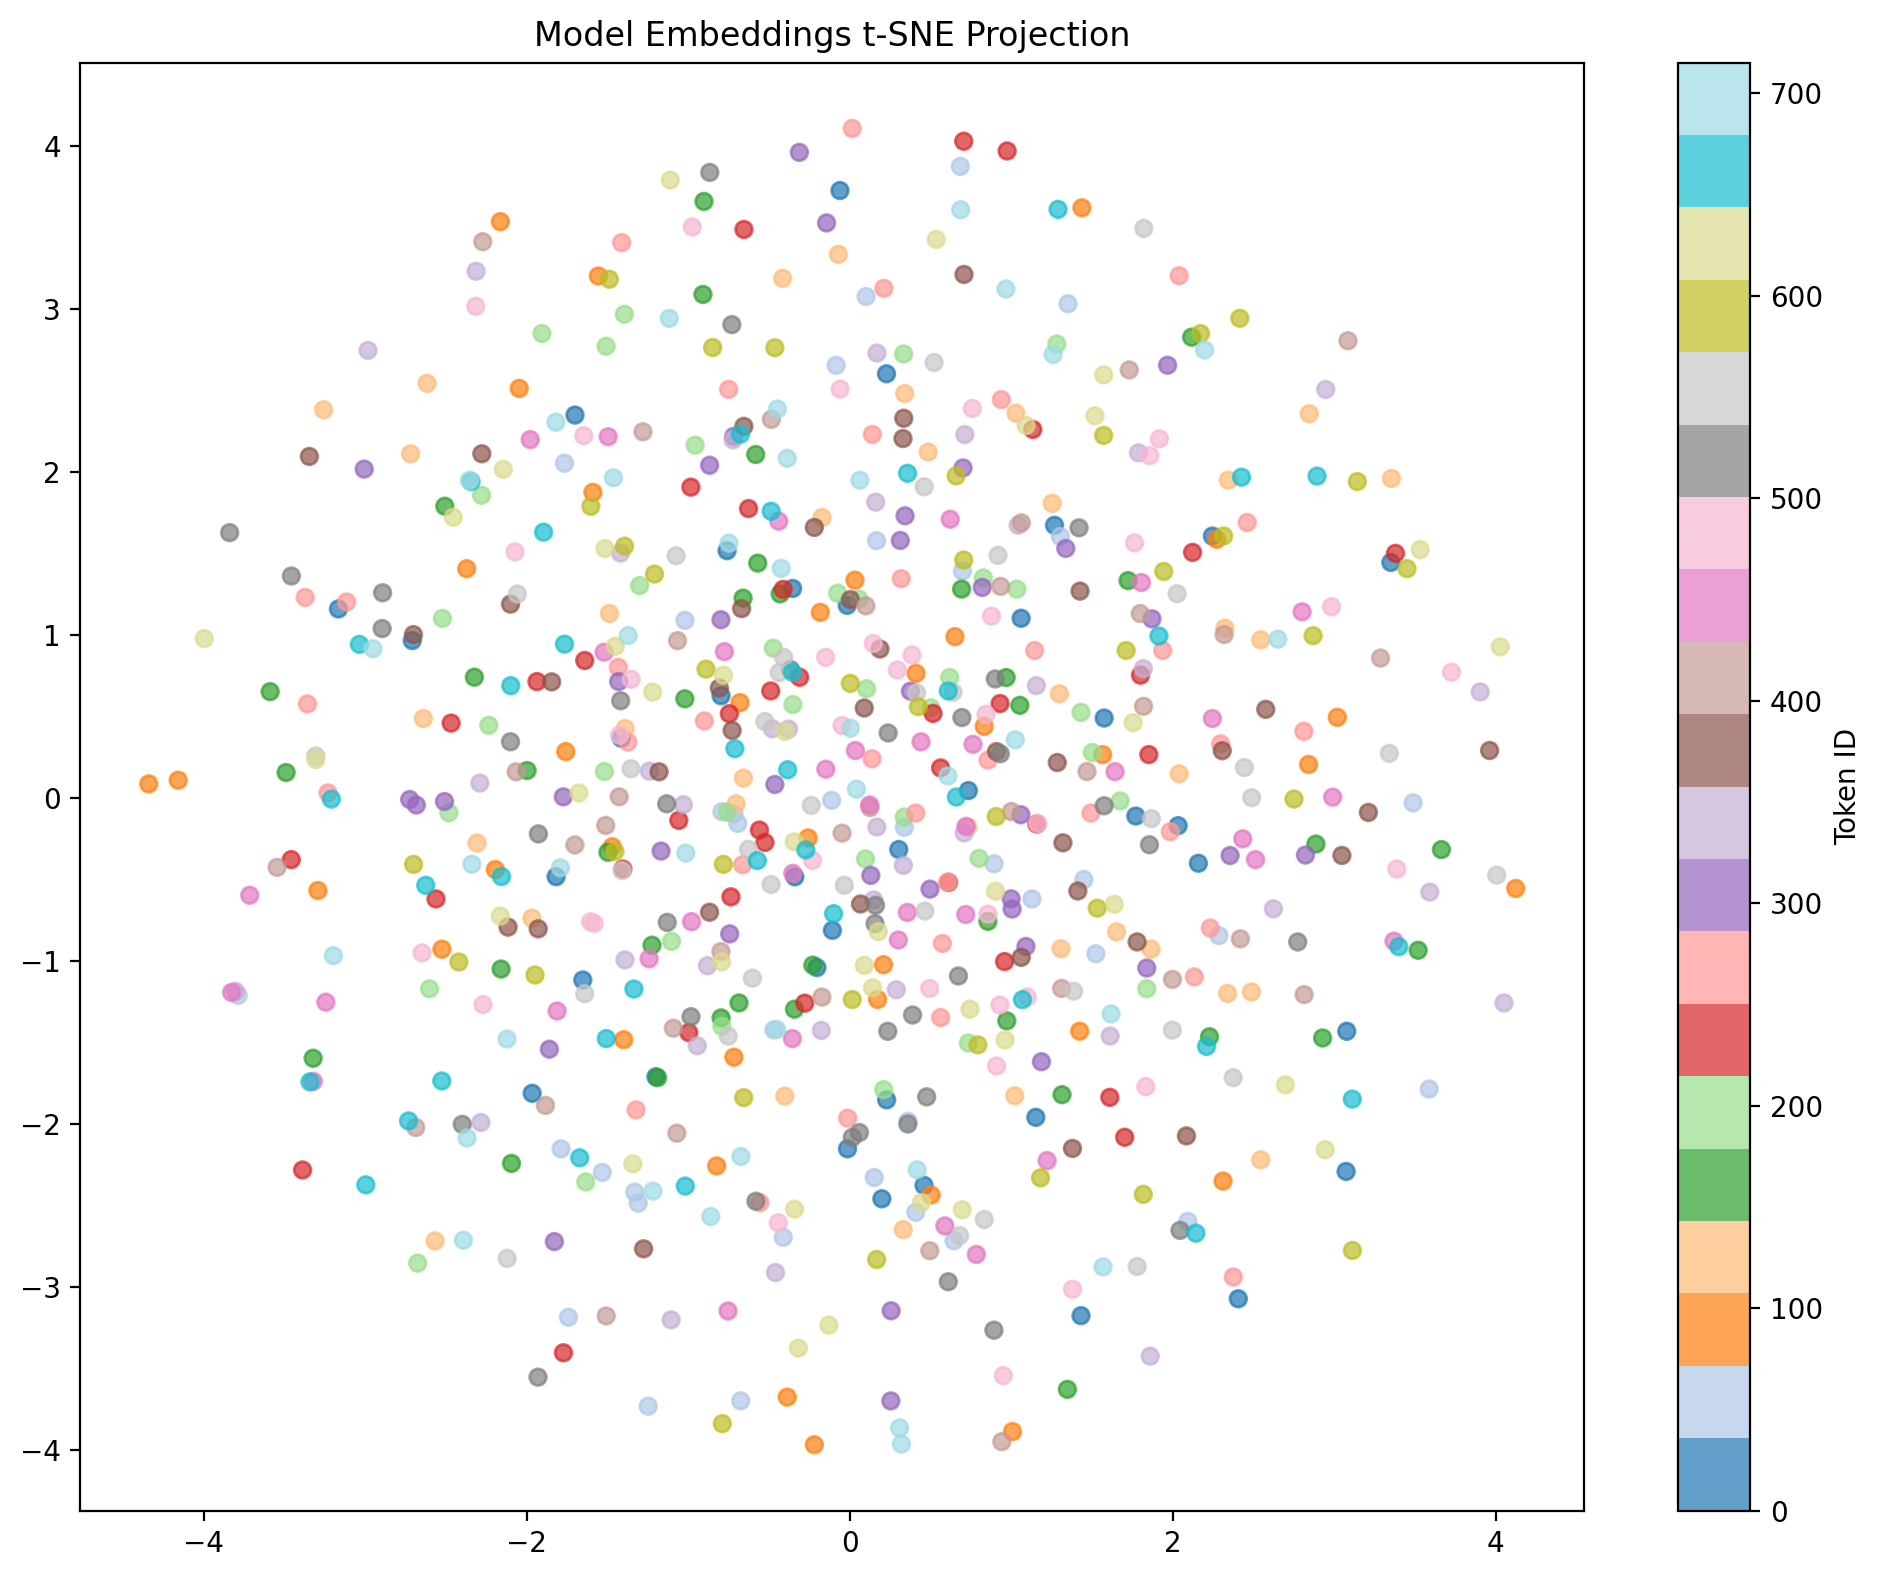

training:   1%|          | 647/100000 [05:40<15:36:13,  1.77it/s]

In [ ]:
for i in tqdm.tqdm(range(NUM_BATCHES - completed_iterations), mininterval = 10., desc = 'training'):
    model.train()

    data = next(train_loader)["input_ids"].to(device)
    if data.shape[0] != BATCH_SIZE:
        print(f'Skipping batch {i} as it is not of size {BATCH_SIZE}, but {data.shape[0]}')
        data = next(train_loader)["input_ids"].to(device)

    train_loss = 0.
    with model.knn_memories_context(batch_size = BATCH_SIZE) as knn_memories:
        xl_memories = None    
        seq, labels = data[:, :-1], data[:, 1:]

        for seq_segment, labels_segment in zip(seq.chunk(SEGMENTS, dim = -1), labels.chunk(SEGMENTS, dim = -1)):
            loss, xl_memories = model(
                seq_segment,
                labels = labels_segment,
                knn_memories = knn_memories,
                xl_memories = xl_memories
            )

            train_loss += loss.item() / SEGMENTS
            (loss / SEGMENTS).backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
    optimizer.step()
    optimizer.zero_grad()

    if not (i % VALIDATE_EVERY):
        model.eval()

        valid_data = next(valid_loader)["input_ids"].to(device)
        if valid_data.shape[0] != BATCH_SIZE:
            print(f'Skipping validation batch {i} as it is not of size {BATCH_SIZE}, but {valid_data.shape[0]}')
            valid_data = next(valid_loader)["input_ids"].to(device)

        valid_loss = 0.

        with torch.no_grad(), model.knn_memories_context(batch_size = BATCH_SIZE) as knn_memories:
            xl_memories = None    
            seq, labels = data[:, :-1], data[:, 1:]

            for seq_segment, labels_segment in zip(seq.chunk(SEGMENTS, dim = -1), labels.chunk(SEGMENTS, dim = -1)):
                loss, xl_memories = model(
                    seq_segment,
                    labels = labels_segment,
                    knn_memories = knn_memories,
                    xl_memories = xl_memories
                )

                valid_loss += loss.item() / SEGMENTS

        save_checkpoint(optimizer, i + completed_iterations, train_loss, valid_loss)

# Initial Results

With the base REMI vocab size of 411 tokens along with the same embed / head / layer count as our hand built model, the results are significantly worse. The training curve almost immediately flattened out at 1.6 loss, compared to under 1.0 previously.

This could be due to e.g.

- Different encoding. Not only are tokens different in MidiTok / Remi but we used bar / beat *embeddings* rather than tokens previously. There are so many more meanings to the tokens in addition to the count rather than just note / duration / sos / eos / pad that it would be much harder to guess the right answer. If we do see convergence it should mean we have learnt more useful information rather than just gamed the system so to speak.
- Larger vocabulary = more choices to pick for the next token
- The MIDITok data loader only provides max `CHUNK_LENGTH` tokens, whereas our custom 'contiguous' data loader always fed in entire tracks. Only a handful of tracks are between 1 and 2k tokens, most are 3 - 5K, so are being split into multiple pieces.
- The LucidRains Memorizing Transformers architecture is very similar to our model but there are a couple of changes (memory on a subset of layer vs all, lack of absolute embeddings) and of course it is a different implementation. I would expect it to be less buggy if anything though.

I did have to tweak the transformer's KNN memory to run exclusively on the GPU as index was on CPU and the data on disk, which was a major bottleneck (as found in our model). Luckily once again the code was nearly identical so it was easy to follow / edit.

## Things to try

- Train the tokenizer with 1K, 5K, 10K, 20K, 30K size vocab. This should result in less tokens per song. We might need to drop the max seq length to avoid over-padded songs.

- Add in chord / tempo / time sig / rest tokens. This should result in more tokens per song. We might need to increase the max seq length to avoid over-split songs.

> Note - the files will need re-encoding as they are split based on estimated token length, which depends on encoding and vocab size!

> Another note! - When the vocab size was halved, the number of tokens per file seemed to double, as you might expect given the bpe was trained on the same data. That meant doubling the chunk size and segment count in order to split the files into the same number of pieces.

- Augment the dataset with pitch and velocity shifted versions using the MIDITok tools

- Full Lakh dataset, although if we can't do well on a curated, stylistic dataset then a more varied one is likely to decrease performance.


## Experiment log

- Was seeing increase in loss after initial drop which eventually came back down again. Decreasing learning rate made it happen later and worse. Increased learning rate (and added dropout) which seemed to negate it.

- Some apparent cyclic loss patterns so tried shuffling between epochs. Requires either waiting for a pretokenise op between epochs (long even on vg_large, let alone Lakh) or tokenise on the fly which reduces GPU usage to around 70%

# RLHF

For non-verifiable domains we can train a model to mimic the preferences of humans.

First we generate n continuations and get a human to rank them. Secondly, we train a separate NN to generate scores for each continuation and compare them to the rankings, then nudge the weights appropriately. Eventually we will have an automated preference model, which we can use to fine tune our generator at scale.

NOTE - with non-concrete answers (i.e. a preference model rather than known answers) you can't train indefinitely as you will see degrading performance. The model finds ways to game the system, getting high scores for obscure results by finding gaps in the reward model (which is by definition a very simplified, limited version of a human's opinion).

# More experiments

- Increasing vocab with BPE decreases performance, likely due to sparsity of occurences of any new tokens given the small data set.

- Adding Chord tokens significantly increased perf

- Adding Tempo tokens raised the vocab size but only slightly decreased perf from Chord only

- To try
    - Time signature tokens = better handling of non-4/4
    - Tempo / time sig optimisations (remove duplicates / only insert when change) = Less wasted tokens in context window
    - Use bigger chunks = compensate for longer sequences caused by chord / time sig / tempo tokens, more memories maintained in KNN db
    - Rest tokens - better handling of silence
    - Memorizing Transformers tweaks (e.g. shift mems down a layer, increase / decrease top K)
    - Lakh dataset = much more variation, and the improved tokenizer has a better chance of capturing it - no need to convert to piano, handles drums and all the other metrics discussed above etc.
    - Try BPE with Lakh dataset. Much larger example size could actually find more genuinely common token merges.
    - Increase model param count (embed size, num layers, heads per layer etc.)

## Basic vocab

In [ ]:
tokenizer_basic_path = Path(f'../data/vocab/MidiTok/vg_large_411_Basic.json')
basic_tokenizer = REMI(params=tokenizer_basic_path)

basic_model_name = f'memorizing_miditok_vg_large_t-512_v-411_1'
basic_model_load_path = Path(f'../data/checkpoints/{basic_model_name}.dat')
basic_model = MemorizingTransformer(
    num_tokens = 411,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

basic_model.load_state_dict(torch.load(basic_model_load_path)['model_state_dict'])

visualize_model_embeddings(basic_model, basic_tokenizer)

## Chords

In [ ]:
tokenizer_chords_path = Path(f'../data/vocab/MidiTok/vg_large_425_Chords.json')
chords_tokenizer = REMI(params=tokenizer_chords_path)

chords_model_name = f'memorizing_miditok_vg_large_t-512_v-425_Chords'
chords_model_load_path = Path(f'../data/checkpoints/{chords_model_name}.dat')
chords_model = MemorizingTransformer(
    num_tokens = 425,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chords_model.load_state_dict(torch.load(chords_model_load_path)['model_state_dict'])

visualize_model_embeddings(chords_model, chords_tokenizer)

## Chords and Tempos

In [ ]:
tokenizer_chords_tempos_path = Path(f'../data/vocab/MidiTok/vg_large_457_Chords_Tempos.json')
chords_tempos_tokenizer = REMI(params=tokenizer_chords_tempos_path)

chords_tempos_model_name = f'memorizing_miditok_vg_large_t-512_v-457_Chords_Tempos'
chords_tempos_model_load_path = Path(f'../data/checkpoints/{chords_tempos_model_name}.dat')
chords_tempos_model = MemorizingTransformer(
    num_tokens = 457,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chords_tempos_model.load_state_dict(torch.load(chords_tempos_model_load_path)['model_state_dict'])

visualize_model_embeddings(chords_tempos_model, chords_tempos_tokenizer)

## Chords, Tempos and Time Signatures

In [ ]:
tokenizer_chords_tempos_time_sig_path = Path(f'../data/vocab/MidiTok/vg_large_530_Chords_Tempos_TimeSig.json')
chords_tempos_time_sig_tokenizer = REMI(params=tokenizer_chords_tempos_time_sig_path)

chords_tempos_time_sig_model_name = f'memorizing_miditok_vg_large_t-512_v-530_Chords_Tempos_TimeSig'
chords_tempos_time_sig_model_load_path = Path(f'../data/checkpoints/{chords_tempos_time_sig_model_name}.dat')
chords_tempos_time_sig_model = MemorizingTransformer(
    num_tokens = 530,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chords_tempos_time_sig_model.load_state_dict(torch.load(chords_tempos_time_sig_model_load_path)['model_state_dict'])

visualize_model_embeddings(chords_tempos_time_sig_model, chords_tempos_time_sig_tokenizer)

## Chords, Tempos, Time Signatures and Rests

In [ ]:
tokenizer_chords_tempos_time_sig_rests_path = Path(f'../data/vocab/MidiTok/vg_large_562_Chords_Tempos_TimeSig_Rests.json')
chords_tempos_time_sig_rests_tokenizer = REMI(params=tokenizer_chords_tempos_time_sig_rests_path)

chords_tempos_time_sig_rests_model_name = f'memorizing_miditok_vg_large_t-512_v-562_Chords_Tempos_TimeSig_Rests'
chords_tempos_time_sig_rests_model_load_path = Path(f'../data/checkpoints/{chords_tempos_time_sig_rests_model_name}.dat')
chords_tempos_time_sig_rests_model = MemorizingTransformer(
    num_tokens = 562,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chords_tempos_time_sig_rests_model.load_state_dict(torch.load(chords_tempos_time_sig_rests_model_load_path)['model_state_dict'])

visualize_model_embeddings(chords_tempos_time_sig_rests_model, chords_tempos_time_sig_rests_tokenizer)

## Chords, Tempos, Time Signatures and Rests (Optimised)

In [ ]:
tokenizer_chords_tempos_time_sig_rests_optimized_path = Path(f'../data/vocab/MidiTok/vg_large_562_Chords_Tempos_TimeSig_Rests_Optimized.json')
chords_tempos_time_sig_rests_optimized_tokenizer = REMI(params=tokenizer_chords_tempos_time_sig_rests_optimized_path)

chords_tempos_time_sig_rests_optimized_model_name = f'memorizing_miditok_vg_large_t-512_v-562_Chords_Tempos_TimeSig_Rests_Optimized'
chords_tempos_time_sig_rests_optimized_model_load_path = Path(f'../data/checkpoints/{chords_tempos_time_sig_rests_optimized_model_name}.dat')
chords_tempos_time_sig_rests_optimized_model = MemorizingTransformer(
    num_tokens = 562,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chords_tempos_time_sig_rests_optimized_model.load_state_dict(torch.load(chords_tempos_time_sig_rests_optimized_model_load_path)['model_state_dict'])

visualize_model_embeddings(chords_tempos_time_sig_rests_optimized_model, chords_tempos_time_sig_rests_optimized_tokenizer)

## Chords with Roots, Tempos, Time Signatures and Rests

In [ ]:
tokenizer_chordroots_tempos_time_sig_rests_path = Path(f'../data/vocab/MidiTok/vg_large_716_ChordsRoots_Tempos_TimeSig_Rests_Optimized.json')
chordroots_tempos_time_sig_rests_tokenizer = REMI(params=tokenizer_chordroots_tempos_time_sig_rests_path)
chordroots_tempos_time_sig_rests_model_name = f'memorizing_miditok_vg_large_t-512_v-716_ChordsRoots_Tempos_TimeSig_Rests_Optimized'
chordroots_tempos_time_sig_rests_model_load_path = Path(f'../data/checkpoints/{chordroots_tempos_time_sig_rests_model_name}.dat')
chordroots_tempos_time_sig_rests_model = MemorizingTransformer(
    num_tokens = 716,
    dim = N_EMBED,
    depth = N_LAYER,
    heads = N_HEAD,
    dim_head = DIM_HEAD,
    attn_dropout = 0.2,
    ff_dropout = 0.2,
    memorizing_layers = (4, 5),
    max_knn_memories = CHUNK_LENGTH, # No point in having more meories than the chunk length as we clear them at the end of each chunk
    num_retrieved_memories = 32, # Top K
    xl_memory_layers = (2, 3, 4, 5),
    xl_max_memories = TIMESTEPS, # One context-length of XL memory
    pad_id = tokenizer.pad_token_id,)

chordroots_tempos_time_sig_rests_model.load_state_dict(torch.load(chordroots_tempos_time_sig_rests_model_load_path)['model_state_dict'])

visualize_model_embeddings(chordroots_tempos_time_sig_rests_model, chordroots_tempos_time_sig_rests_tokenizer)

In [ ]:
random_test_path = random.choice(test_chunk_filepaths)
random_train_data = tokenizer.encode(random_test_path)
print(f'Random test file: {random_test_path}')

In [ ]:
from symusic import Synthesizer
synth = Synthesizer()

random_start_tokens = random_train_data.tokens[:TIMESTEPS] # TODO: Think about checking / enforcing the correct length
random_start_ids = random_train_data.ids[:TIMESTEPS]

random_start_decoded = tokenizer.decode(random_start_tokens)
audio = synth.render(random_start_decoded)
IPython.display.Audio(audio, rate=44100)

In [ ]:
model.eval()

input_ids = torch.tensor([random_start_ids]).to(device)

generated = model.generate(
        input_ids = input_ids,
        max_length = CHUNK_LENGTH,
        eos_token_id = tokenizer["EOS_None"]).detach().cpu()[0]
    
score = tokenizer.decode(generated)
generated_decoded = tokenizer.decode(generated)
audio = synth.render(generated_decoded)
IPython.display.Audio(audio, rate=44100)